# Answering Business Questions Using SQL
Author: Jimmy Nguyen (github.com/jnguyen)

# Introduction
In this project, I answer some business questions about the Chinook database. The Chinook database represents an example of an audio store database containing relational tables regarding employees, customers, billing, and audio tracks sold by the Chinook store.

To access and answer questions about the Chinook database, I use the `sqlite3` library to query the database, stored as `chinook.db`, using SQLite 3. The `sqlite3` library allows Python users to interact with SQLite3 database objects within Python. This is nice because it us to work with SQL in a Jupyter notebook, which enables the analyst to communicate about queries as they are made.

The Chinook database is pictured below:
![Chinook Database Schema](chinook_schema.svg)

In [2]:
# Import data analysis libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sqlite3

%matplotlib inline

## Helper Functions to Query Database
To facilitate running queries in Python, we'll define a couple helper functions.

* `run_query(q)`: Runs a SQLite query and returns a pandas dataframe
    * `sqlite3`'s context manager handles opening/closing the connection to minimize user error and accidental changes (aka damage!) to the database
* `run_command(c)`: Runs a SQLite command in autocommit mode and executes using the `sqlite3` module
    * This is useful for making changes to the database
* `show_tables()`: Helper function that returns a list of all tables and views in the database
    * Uses `run_query()` from above

In [3]:
# Run a SQLite 3 query
# Returns: pandas.DataFrame
def run_query(q, db='chinook.db'):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

# Runs a SQLite 3 command in autocommit mode
# Returns: nothing
def run_command(c, db='chinook.db'):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None # autocommit mode
        conn.execute(c)
        
# Display a DataFrame of all tables and views in the database
# Returns: pandas.DataFrame
def show_tables(db='chinook.db'):
    q = """
    SELECT name, type
    FROM sqlite_master
    WHERE type IN ('table', 'view');
    """
    return run_query(q, db)

In [4]:
# List of tables and views in the chinook database
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Answering Business Questions

## Question: Which new albums should Chinook purchase for the store?
**Situation:** Chinook has just signed a deal with a new record label, and we want to know which three of four artists should Chinook purchase albums for sale in the store. The artista and their genre of music are shown in the table below.

| *Artist Name*        | *Genre* |
|----------------------|---------|
| Regal                | Hip-Hop |
|  Red Tone            | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |

**Approach:** We can rank the genres of the artists by total sales in the USA and use the resulting ranked list to recommend artists. The idea here is to recommend the artists that represent the highest grossing genres relative to each other.

### Quality check: do customer mailing country differ from their billing country?
The Chinook database has both customer country and associated billing country for each invoice generated by customer. If a customer's billing country differs from their country of origin (i.e. mailing address), we would defer to customer country (in the `customer` table) to determine the country in which the sale took place. Before we jump the gun, let's check if there are any differences in the columns.

In [87]:
# Which customers have billing countries different from their mailing country on any invoice?
# Answer: none
q = """
SELECT country, billing_country
FROM customer
    INNER JOIN invoice
    ON customer.customer_id = invoice.customer_id
WHERE country != billing_country;
"""

cust_country_billing = run_query(q)
cust_country_billing.empty

True

Phew! Since there are no discrepancies, we can use `billing_country` from the `invoice` table to filter all invoices to those originating in the US, which has the value `USA`. Just to triple check, we can check for unique values of `billing country` to ensure there are no other values, such as `US` or `United States`.

In [6]:
# Check 2: are there different spellings of countries we should worry about?
# Answer: no
q = """
SELECT DISTINCT billing_country
FROM invoice;
"""
unique_countries = run_query(q)
unique_countries

,billing_country
0,USA
1,Canada
2,France
3,Poland
4,India
5,Germany
6,Portugal
7,Finland
8,Brazil
9,Denmark


Looks like the database is very clean and Chinook picked the right data engineers ;), so we can proceed to do a simple query aggregating all the sales for each genre. We'll accomplish this by grouping by genre.

In [88]:
## Query: Track sales by genre in the USA
q = """
SELECT g.name genre,
    COUNT(*) tracks_sold,
    SUM(il.unit_price * il.quantity) total_sales
FROM invoice i
    INNER JOIN invoice_line il
    ON i.invoice_id = il.invoice_id
    INNER JOIN track t
    ON il.track_id = t.track_id
    INNER JOIN genre g
    ON t.genre_id = g.genre_id
WHERE i.billing_country = 'USA'
GROUP BY g.name
ORDER BY total_sales DESC;
"""

genre_sales_usa = run_query(q)
genre_sales_usa['pc_sales'] = (genre_sales_usa['tracks_sold']/genre_sales_usa['total_sales'].sum(axis=0) * 100).round(1)
genre_sales_usa

,genre,tracks_sold,total_sales,pc_sales
0,Rock,561,555.39,53.9
1,Alternative & Punk,130,128.70,12.5
2,Metal,124,122.76,11.9
3,R&B/Soul,53,52.47,5.1
4,Blues,36,35.64,3.5
5,Alternative,35,34.65,3.4
6,Latin,22,21.78,2.1
7,Pop,22,21.78,2.1
8,Hip Hop/Rap,20,19.80,1.9
9,Jazz,14,13.86,1.3


In [89]:
# Borrow plotting theme code from StackOverflow: 
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 18
BIGGEST_SIZE = 24

plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
sns.set_style('white')

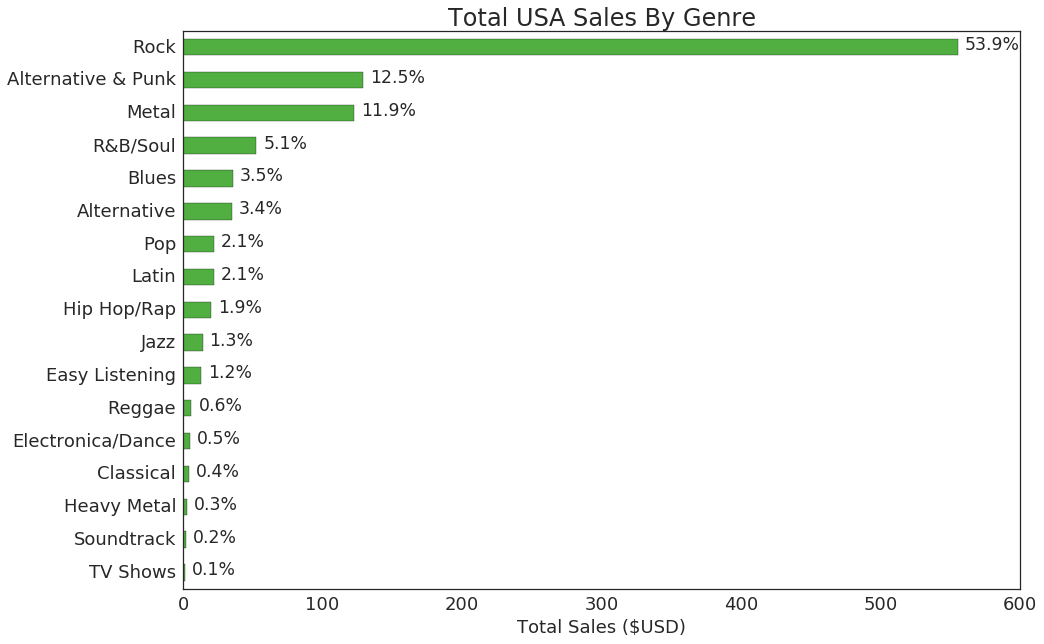

In [91]:
## Visualize quantity sold for all genres
genre_sales_usa = genre_sales_usa.sort_values('tracks_sold')
ax = genre_sales_usa.plot(kind='barh',
                     x='genre', y='total_sales',
                     figsize=(15,10),
                     title='Total USA Sales By Genre',
                     legend=False,
                     color=plt.cm.Paired(0.25))
plt.xlabel('Total Sales ($USD)')
plt.ylabel('')

# Add text annotations to bar graph
for rect, idx in zip(ax.patches, genre_sales_usa.index):
    width = rect.get_width()
    ax.text(width + 5, # place text slightly to right of bar
            rect.get_y() + rect.get_height() / 10, # center text with bar
            genre_sales_usa['pc_sales'].sort_values(ascending=False).iloc[idx].astype(str) + '%', # output float with percentage
            ha='left', va='bottom',
            size='x-large')# align text

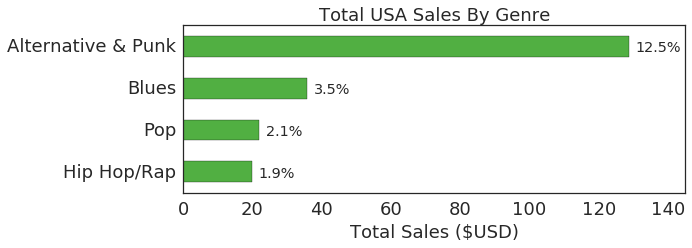

In [92]:
## Visualize quantity sold for new artist genres in question
artist_genres = ['Hip Hop/Rap', 'Alternative & Punk', 'Pop', 'Blues']
rec_genre_usa = genre_sales_usa[genre_sales_usa.genre.isin(artist_genres)].reset_index()

plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels

ax = rec_genre_usa.plot(kind='barh',
                     x='genre', y='total_sales',
                     figsize=(9,3),
                     title='Total USA Sales By Genre',
                     legend=False,
                     color=plt.cm.Paired(0.25))
ax.set_xlim(0, 145)
plt.xlabel('Total Sales ($USD)')
plt.ylabel('')


# Add text annotations to bar graph
for rect, idx in zip(ax.patches, rec_genre_usa.index):
    width = rect.get_width()
    ax.text(width + 2, # place text slightly to right of bar
            rect.get_y() + rect.get_height() / 10, # center text with bar
            rec_genre_usa['pc_sales'].iloc[idx].astype(str) + '%', # output float with percentage
            ha='left', va='bottom',
            size='large')# align text

### Recommendation: Red Tone, Slim Jim Blues, and Meteor and the Girls
Alternative & Punk, Blues, and Pop were the three highest grossing genres in the database. The new artists that produce music in these genres are Red Tone, Slim Jim Blues, and Meteor and the Girls. Chinook should purchase their albums for sale in the store.

**Verdict:** Buy albums from

* Red Tone
* Slim Jim Blues
* Meteor and the Girls

## Question: How are our sales support agents performing?
**Situation:** Each customer for the Chinook store gets assigned to a sales support agent when they first make a purchase. We want to examine the performance of each sales support agent by the number of purchases belonging to each employee.

**Approach:** We can look at the total sales associated with each employee and rank them accordingly. We'll look at sales both as an aggregate total, and by year.

In [11]:
# Query: total sales by employee, with hire date
q = """
SELECT e.first_name || ' ' || e.last_name employee_name,
    e.title,
    DATE(e.hire_date) hire_date,
    SUM(CASE 
            WHEN il.unit_price IS NULL THEN 0
            ELSE il.unit_price * il.quantity
        END) total_sales
FROM employee e
    INNER JOIN customer c
    ON e.employee_id = c.support_rep_id
    INNER JOIN invoice i
    ON c.customer_id = i.customer_id
    INNER JOIN invoice_line il
    ON i.invoice_id = il.invoice_id
GROUP BY e.first_name, e.last_name
ORDER BY 
        SUM(CASE 
            WHEN il.unit_price IS NULL then 0
            ELSE il.unit_price * il.quantity
        END),
        e.first_name, e.last_name;
"""

employee_sales = run_query(q)
employee_sales

,employee_name,title,hire_date,total_sales
0,Steve Johnson,Sales Support Agent,2017-10-17,1393.92
1,Margaret Park,Sales Support Agent,2017-05-03,1584.00
2,Jane Peacock,Sales Support Agent,2017-04-01,1731.51


In [12]:
# Query: Get employee sales grouped by year
# Note: We also have month data in case that is of interest
# Note 2: To properly account for months, one would need to use
# a cross join of possible year-month combos to account for
# potential $0 sales months (i.e. null rows in invoice)
q = """
WITH invoice_group AS (
    SELECT
        invoice.*,
        strftime('%Y', invoice_date) invoice_year,
        strftime('%m', invoice_date) month,
        strftime('%Y-%m-01', invoice_date) year_month,
        -- Convert months to named months
        CASE
            WHEN strftime('%m', invoice_date) = '01' THEN 'January'
            WHEN strftime('%m', invoice_date) = '02' THEN 'February'
            WHEN strftime('%m', invoice_date) = '03' THEN 'March'
            WHEN strftime('%m', invoice_date) = '04' THEN 'April'
            WHEN strftime('%m', invoice_date) = '05' THEN 'May'
            WHEN strftime('%m', invoice_date) = '06' THEN 'June'
            WHEN strftime('%m', invoice_date) = '07' THEN 'July'
            WHEN strftime('%m', invoice_date) = '08' THEN 'August'
            WHEN strftime('%m', invoice_date) = '09' THEN 'September'
            WHEN strftime('%m', invoice_date) = '10' THEN 'October'
            WHEN strftime('%m', invoice_date) = '11' THEN 'November'
            WHEN strftime('%m', invoice_date) = '12' THEN 'December'
        END invoice_month
    FROM invoice
)


SELECT e.first_name || ' ' || e.last_name employee_name,
    e.title,
    i.invoice_year,
    SUM(CASE 
            WHEN il.unit_price IS NULL THEN 0
            ELSE il.unit_price * il.quantity
        END) total_sales
FROM employee e
    INNER JOIN customer c
    ON e.employee_id = c.support_rep_id
    INNER JOIN invoice_group i
    ON c.customer_id = i.customer_id
    INNER JOIN invoice_line il
    ON i.invoice_id = il.invoice_id
GROUP BY e.first_name, e.last_name, i.invoice_year
ORDER BY 
        e.first_name, e.last_name,
        i.invoice_year
"""

employee_sales_time = run_query(q)
employee_sales_time.invoice_year = pd.to_datetime(employee_sales_time['invoice_year'], format = '%Y')
employee_sales_time

,employee_name,title,invoice_year,total_sales
0,Jane Peacock,Sales Support Agent,2017-01-01,532.62
1,Jane Peacock,Sales Support Agent,2018-01-01,413.82
2,Jane Peacock,Sales Support Agent,2019-01-01,383.13
3,Jane Peacock,Sales Support Agent,2020-01-01,401.94
4,Margaret Park,Sales Support Agent,2017-01-01,416.79
5,Margaret Park,Sales Support Agent,2018-01-01,400.95
6,Margaret Park,Sales Support Agent,2019-01-01,400.95
7,Margaret Park,Sales Support Agent,2020-01-01,365.31
8,Steve Johnson,Sales Support Agent,2017-01-01,252.45
9,Steve Johnson,Sales Support Agent,2018-01-01,332.64


### Plot: Employee Total Sales By Year

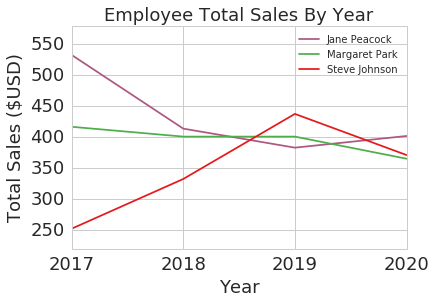

In [13]:
#employee_sales_time.pivot(index='invoice_year',
#                          columns='employee_name',
#                          values='total_sales')
sns.set_style('whitegrid')
emp_colors = plt.cm.Set1([0.4,0.25,0])
ax = employee_sales_time.pivot_table(values='total_sales',
                                index='invoice_year',
                                columns=['employee_name']).plot(color=emp_colors)
ax.legend().set_title('') # disable legend title
plt.xlabel('Year')
plt.ylabel('Total Sales ($USD)')
ax.set_ylim(220, 580)
plt.title('Employee Total Sales By Year')

### Plot: Employee Total Sales Overall

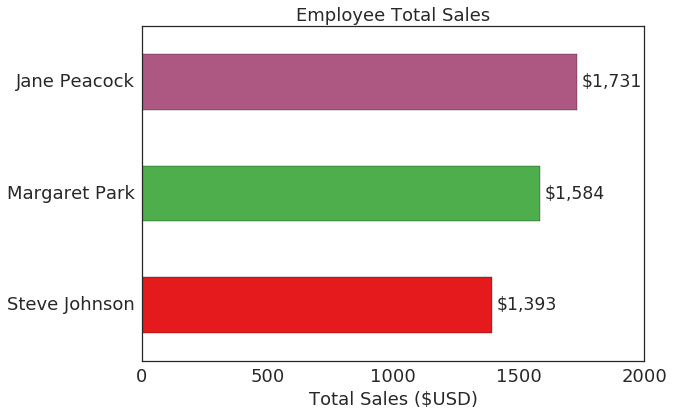

In [14]:
sns.set_style('white')
ax = employee_sales.plot(kind='barh',
                     x='employee_name', y='total_sales',
                     figsize=(9,6),
                     title='Employee Total Sales',
                     legend=False,
                     rot=0,
                     color=emp_colors[::-1]) # keep colors consistent for each employee
ax.set_xlim(0,2000)
plt.xlabel('Total Sales ($USD)')
plt.ylabel('')

# Add text annotations to bar graph
for rect, idx in zip(ax.patches, rec_genre_usa.index):
    width = rect.get_width()
    ax.text(width + 20, # place text slightly to right of bar
            rect.get_y() + rect.get_height() / 3, # center text with bar
            '$' + "{:,}".format(employee_sales['total_sales'].iloc[idx].astype(int)), # output $x,xxx
            ha='left', va='bottom', # align text
            size='x-large') 

### Ranking: Jane > Steven > Margaret
There are three sales support agents in the database. This is the rank of the sales support agents by total sales:

| *Rank* | *Sales Rep*   | *Hire Date*  | *Total Sales* |
|--------|---------------|--------------|---------------|
| 1      | Jane Peacock  | April 2017   | 1731.50       |
| 2      | Margaret Park | May 2017     | 1584.00       |
| 3      | Steve Johnson | October 2017 | 1393.92       |

We note that total sales over time only shows total contribution to the company. Naturally, an employee that was hired earlier is more likely to have higher sales by simply being at the company longer. 

A better measure of performance is total sales by year, which shows employee performance over time. Looking at the 2020 results, we find a slightly different ranking from above:

| *Rank* | *Sales Rep*    | *2020 Sales*  |
|--------|----------------|---------------|
| 1      | Jane Peacock   | 401.94        |
| 2      | Steven Johnson | 371.25        |
| 3      | Margaret Park  | 365.31        |

**Discussion:** Combining with the plot over time of sales I created above, the second table has the more reasonable ranking. Jane Peacock did the worst last year, but picked it back up and has been a consistent performer for the company. Steven Johnson was brought on last and was a star performer in 2019, and continues to have good performance in 2020. Margaret Park has been slightly underperforming the rest, but not so much as to present any worry.

**Verdict:**

| *Rank* | *Sales Rep*    |
|--------|----------------|
| 1      | Jane Peacock   |
| 2      | Steven Johnson |
| 3      | Margaret Park  |


## Question: What do our sales look like in the different countries we serve?
**Situation:** Chinook wants to know, by country, the

1. total number of customers
2. total value of sales
3. average value of sales per customer
4. average order value

The manager also mentioned to use the `customer` table to determine customer country.

**Approach:** This is a routine report generation that can be done by grouping by country and using SQL aggregation. To make the results easier to digest, we will collect countries for which we only have one customer in an 'Other' category. We'll use the results to answer an underlying question: **In which countries does Chinook have potential for growth?**

In [15]:
q = """
-- Subquery: pool countries with 1 customer only as "Other"
WITH customer_other AS (
    SELECT
        country,
        CASE
            WHEN COUNT(*) = 1 THEN 'Other'
            ELSE country
        END country_other,
        COUNT(*) AS num_customers,
        -- Sorting column to force 'Other' to show up at end of query
        CASE
            WHEN COUNT(*) = 1 THEN 1
            ELSE 0
        END sort_other_last
    FROM customer
    GROUP BY country
    ORDER BY
        CASE
            WHEN COUNT(*) = 1 THEN 1
            ELSE 0
        END
)

SELECT co.country_other "Country",
    COUNT(DISTINCT c.customer_id) "Total Customers",
    ROUND(SUM(il.unit_price * il.quantity),2) "Total Sales",
    ROUND(SUM(il.unit_price * il.quantity)/COUNT(DISTINCT c.customer_id),2) "Average Sales Per Customer",
    ROUND(SUM(il.unit_price * il.quantity)/COUNT(DISTINCT i.invoice_id),2) "Average Order Value",
    co.sort_other_last
FROM customer c
    INNER JOIN customer_other co
    ON c.country = co.country
    INNER JOIN invoice i
    ON c.customer_id = i.customer_id
    INNER JOIN invoice_line il
    ON i.invoice_id = il.invoice_id
GROUP BY co.country_other
ORDER BY co.sort_other_last,
    ROUND(SUM(il.unit_price * il.quantity),2) DESC
"""
sales_by_country = run_query(q)
sales_by_country = sales_by_country.set_index('Country')
sales_by_country.drop("sort_other_last", axis=1) # print table without sort order

,Total Customers,Total Sales,Average Sales Per Customer,Average Order Value
Country,,,,
USA,13,1040.49,80.04,7.94
Canada,8,535.59,66.95,7.05
Brazil,5,427.68,85.54,7.01
France,5,389.07,77.81,7.78
Germany,4,334.62,83.66,8.16
Czech Republic,2,273.24,136.62,9.11
United Kingdom,3,245.52,81.84,8.77
Portugal,2,185.13,92.57,6.38
India,2,183.15,91.58,8.72


Now that we have the report data, we can move on to the next natural step: making it digestible for stakeholders. We'll produce a static dashboard in Python using `matplotlib` to visualize the results.

To proceed, we'll need to think about what stakeholders are interested in -- namely, where might there be opportunities for a marketing campaign? One way we can answer this is to look at which countries have the most valuable customers, in terms of average spend number of customers. With this in mind, we'll create a dashboard with the following information:

* Total customers by country
* Total sales by country
* Percent customers vs sales
* Average sales per customer relative to country average

### Plots: Visualizations of Sales By Country

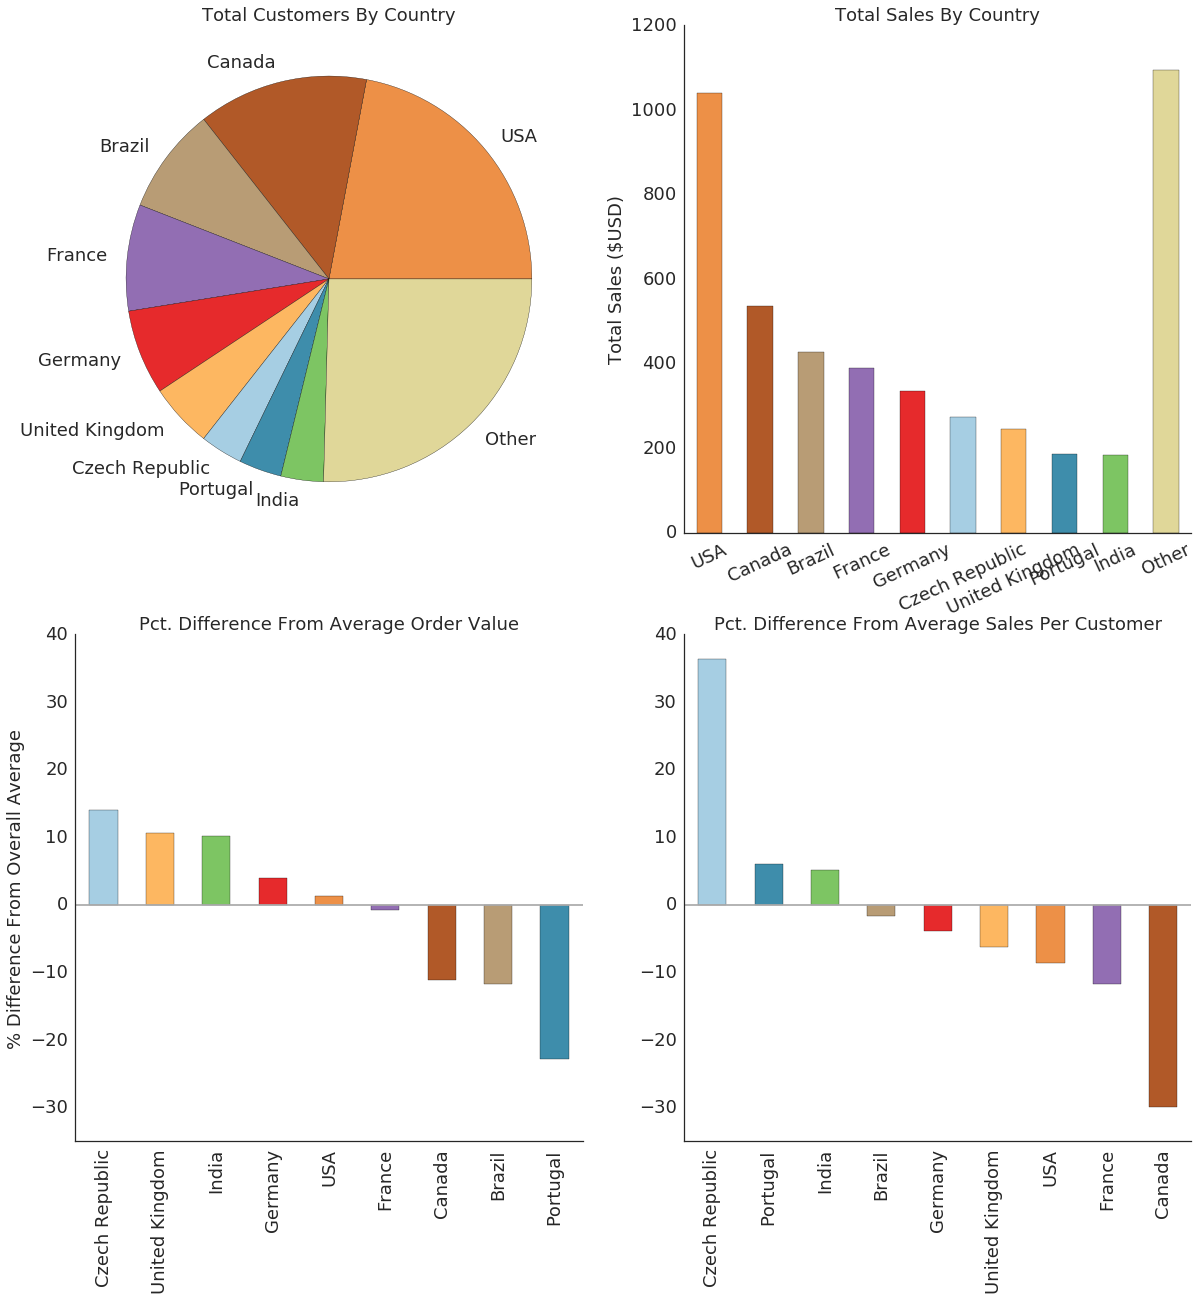

In [94]:
# Assign color to each country to ensure consistent colors regardless of sorting order
sales_by_country['color'] = [plt.cm.Paired(i) for i in np.linspace(0,1,sales_by_country.shape[0])]

# Calculate % difference from overall averages
sales_by_country['pc_diff_avg_order'] = 100*(1 - sales_by_country['Average Order Value'].mean() / sales_by_country['Average Order Value'])
sales_by_country['pc_diff_avg_sales'] = 100*(1 - sales_by_country['Average Sales Per Customer'].mean() / sales_by_country['Average Sales Per Customer'])

# Setup 2x2 grid of plots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
ax1, ax2, ax3, ax4 = ax.flatten()
sns.set_style("white")

# top-left plot: pie chart
sales_by_country = sales_by_country.sort_values(['sort_other_last', 'Total Customers'], ascending=[True,False])
sales_by_country.plot(kind='pie',
                      y="Total Customers",
                      ax=ax1,
                      colors=sales_by_country.color.tolist(),
                      title = "Total Customers By Country",
                      legend=False)
ax1.set_ylabel('')

# top-right plot:
sales_by_country = sales_by_country.sort_values(['sort_other_last', 'Total Sales'], ascending=[True,False])
sales_by_country.plot.bar(ax=ax2,
                          y="Total Sales",
                          color=sales_by_country.color.tolist(),
                          title = "Total Sales By Country",
                          rot=25,
                          legend=False)
ax2.set_xlabel('')
ax2.set_ylabel('Total Sales ($USD)')

# bottom-left plot:
sales_by_country = sales_by_country.sort_values("pc_diff_avg_order", ascending=False)
sales_by_country.drop("Other").plot.bar(ax=ax3,
                          y="pc_diff_avg_order",
                          color=sales_by_country.color.drop("Other").tolist(),
                          title = "Pct. Difference From Average Order Value",
                          legend=False)
ax3.axhline(0, c=(171/255, 171/255, 171/255)) # Tableau gray
ax3.set_xlabel('')
ax3.set_ylabel('% Difference From Overall Average')
ax3.set_ylim(-35,40)

# bottom-right plot:
sales_by_country = sales_by_country.sort_values("pc_diff_avg_sales", ascending=False)
sales_by_country.drop("Other").plot.bar(ax=ax4,
                          y="pc_diff_avg_sales",
                          color=sales_by_country.color.drop("Other").tolist(),
                          title = "Pct. Difference From Average Sales Per Customer",
                          legend=False)
ax4.axhline(0, c=(171/255, 171/255, 171/255)) # Tableau gray
ax4.set_xlabel('')
ax4.set_ylim(-35,40)

# Despine plots
for ax in [ax2,ax3,ax4]:
    sns.despine(ax=ax)

### Recommendations and Observations

A few key observations:

* Chinook's largest markets are USA, Cananda, and Brazil going by total sales and relative share of the customer base
* The Czech Republic, United Kingdom, and India had higher average order values compared to other countries 
    * The Czech Republic generates almost 40% more per customer compared to other countries
    * Customers from India generate slightly more revenue than the overall average per customer, while the UK generates less revenue compared to the overall average
* Customers from Portugal order less per order, but order frequently enough that their customers generate the second highest average sales per customer
    * However, Portugal only has 2 customers, so we should be careful to jump to conclusions

Possible actionable strategies:

* It appears that customers in different countries tend to have different buying strategies: either buy a lot in an order, or frequently buy single tracks
* The Czech Republic is a small but valuable market that orders a lot and orders frequently, so targeting customers in this country should be a priority
* Other candidate countries to target include the UK, India, and Portugal
    * India and the UK order in large quantities at a time, so a strategy focusing on popular artist albums would work well in these countries
    * Portugal has customers that order small amounts frequently, so focusing on popular genres and seeking variety in this market may work well

## Question: Should Chinook alter its purchasing strategy?

**Situation**: The Chinook store, by design, only allows customers to buy in one of two ways:

* Purchase a whole album
* Purchase a collection of one or more tracks

However, customers cannot purchase a whole album and then add individual tracks to the same purchase. The only way to achieve this is to add each desired album's tracks individually and combine that with additional individual track purchases.

There is no difference in price if a customer purchases a full album vs. buying tracks individually.

Management is considering only purchasing the most popular tracks from each album, instead of entire albums.

Chinook wants to know: what percentage of purchases are for individual tracks, or for whole albums?

The answer to this question would provide valuable insight into how changing their purchasing strategy will affect revenue.

**Approach**: The most obvious approach is to look at how many orders contained full album purchases. However, there are some caveats:

* Some albums are only made of one or two tracks
* Customers might add all an album's tracks and other individual tracks, effectively constituting an album + track purchase

Since management is concerned with maximizing revenue, we shouldn't concern ourselves with small albums. Also, the company mentioned that individual album + track purchases don't happen too often, so we don't need to consider that case, as it will not impact the results greatly.

As such, we'll go ahead and write a query that checks whether each invoice contains all the tracks from an album, and summarizes that information as

1. The number of invoices with album purchases
2. The percentage of invoices with album purchases

In [86]:
q = """
-- Subquery that gets all unique invoice lines
WITH all_invoices AS
    (
     SELECT
         il.invoice_id invoice_id,
         il.track_id,
         t.album_id
     FROM invoice_line il
         INNER JOIN track t
         ON il.track_id = t.track_id
     GROUP BY il.invoice_id
    )

SELECT album_purchase,
    COUNT(invoice_id) AS num_invoices,
    100*ROUND(CAST(COUNT(invoice_id) AS FLOAT) /
            (SELECT COUNT(*) FROM invoice),3) AS pc_invoices
FROM
    (
    SELECT al.*,
        -- Correlated subquery: check that all tracks
        -- in each invoice equals all tracks in an
        -- album
        CASE
            WHEN
                (
                SELECT t.track_id
                FROM track t
                WHERE t.album_id = al.album_id
                
                EXCEPT
                
                SELECT il2.track_id
                FROM invoice_line il2
                WHERE il2.invoice_id = al.invoice_id
                ) IS NULL
                
                AND
                
                (
                SELECT il2.track_id
                FROM invoice_line il2
                WHERE il2.invoice_id = al.invoice_id
                
                EXCEPT
                
                SELECT t.track_id
                FROM track t
                WHERE t.album_id = al.album_id
                ) IS NULL
            THEN "yes"
            ELSE "no"
        END AS album_purchase
    FROM all_invoices al
    )
GROUP BY album_purchase
"""
run_query(q)

,album_purchase,num_invoices,pc_invoices
0,no,500,81.4
1,yes,114,18.6


### Recommendation: Do not change purchase strategy
Album purchases account for 18.6% of invoices, so there's the potential to lose one-fifth of the invoices, which can possibly account for over 20% of revenue.

**Alternatively**: Combining with the results from the countries earlier, if management is unsatisfied with this answer, then an alternative is to selectively purchase albums based on how well the track or album would perform in a country. We could achieve this by purchasing full albums for genres that sell in countries with customers that tend to buy full albums (such as India or the UK), and otherwise purchase single tracks from genres that perform well in countries that make frequently, smaller purchases, such as Portugal.

Of course, this result will depend on the vendors, and for that further talks would be needed to assess the viability.

For now, it is best to retain the current strategy and assess the current markets to see if costs can be saved for select purchases.